## Часть 3. [5 баллов] Классификация текстов
Задача классификации формулируется так: данный фрагмент фанфика описывают какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro . Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

Используйте фрагменты из множества train для обучения, из множества dev для отладки, из множества test – для тестирования и получения итоговых результатов.

1. [1 балл] Используйте fastText в качестве baseline-классификатора.
2. [2 балла] Используйте сверточные или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать -max pooling.
3. [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

In [ ]:
!unzip hpac_splits.zip

Archive:  hpac_splits.zip
   creating: hpac_corpus/
  inflating: hpac_corpus/hpac_training_128.tsv  
   creating: __MACOSX/
   creating: __MACOSX/hpac_corpus/
  inflating: __MACOSX/hpac_corpus/._hpac_training_128.tsv  
  inflating: hpac_corpus/hpac_dev_128.tsv  
  inflating: __MACOSX/hpac_corpus/._hpac_dev_128.tsv  
  inflating: hpac_corpus/hpac_test_128.tsv  
  inflating: __MACOSX/hpac_corpus/._hpac_test_128.tsv  
  inflating: __MACOSX/._hpac_corpus  


In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fasttext
import os
import csv
import torch
import numpy as np
import pandas as pd
from gensim.utils import simple_preprocess
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm.notebook import tqdm, trange

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import SGD
import gc

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# Подготовка датасетов

folder_raw = "hpac_corpus"
folder_proc = "ready_data"
models = "models"
paths = ['hpac_training_128.tsv',
         'hpac_dev_128.tsv',
         'hpac_test_128.tsv']

categories = []

if not os.path.exists(folder_proc):
    os.mkdir(folder_proc)

if not os.path.exists(models):
    os.mkdir(models)

for f in paths:
    df = pd.read_csv(os.path.join(folder_raw, f), 
                    sep = '\t',
                    header = None).rename(columns = {2: 'questions', 1: 'category'})

    categories.extend(df["category"].to_list())
    df["questions"] = df["questions"].map(lambda x: ' '.join(simple_preprocess(x)))
    df["category"] = df["category"].map(lambda x: '__label__' + x)
    df[['category', 'questions']].to_csv(os.path.join(folder_proc, f), 
                                            index = False, 
                                            sep = ' ',
                                            header = None, 
                                            quoting = csv.QUOTE_NONE, 
                                            quotechar = "", 
                                            escapechar = " ")

#### 3.1 [1 балл] Используйте fastText в качестве baseline-классификатора.

In [ ]:
# Обучение моделей
base_models = []
for i in [2,3,4]:
    model = fasttext.train_supervised(os.path.join(folder_proc, paths[0]),
                                      wordNgrams = i)
    model.save_model(os.path.join(models, f'base_model_{i}.bin'))
    base_models.append(f'base_model_{i}.bin')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def desribe_predictions(predicted, true_values):
    df = pd.DataFrame()
    df["pred"] = predicted
    df["true"] = true_values

    labels = list(set(predicted))
    df = df[df["true"].isin(labels)]

    cm = confusion_matrix(df["true"], df["pred"], labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels,
                            #   xticks_rotation = "vertical"
                              )
    disp.plot()
    plt.show()

hpac_test_128.tsv


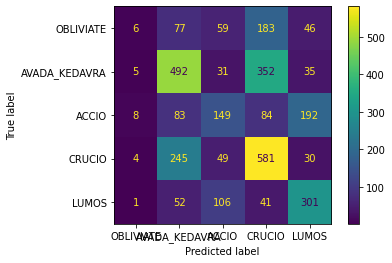

hpac_test_128.tsv


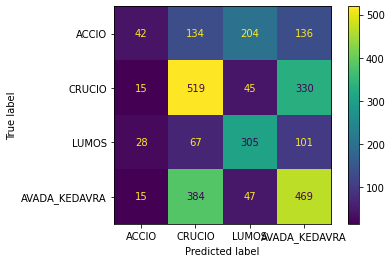

hpac_test_128.tsv


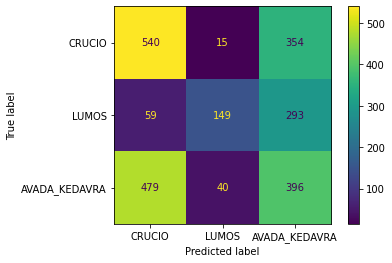

In [ ]:
# Получение предсказаний/подсчет качества
result = pd.DataFrame(columns = paths)
for m in base_models:
    res = {}
    for f in paths:
        df = pd.read_csv(os.path.join(folder_raw, f), 
                        sep = '\t',
                        header = None).rename(columns = {2: 'questions', 1: 'category'})
        df["questions"] = df["questions"].map(lambda x: ' '.join(simple_preprocess(x)))
        # df["category"] = df["category"].map(lambda x: '__label__' + x)
        r = fasttext.load_model(os.path.join(models, m)).predict(df["questions"].to_list())
        df["predicted"] = pd.DataFrame(r[0])[0].map(lambda x: x[9:])
        res[f] = f1_score(df["category"], df["predicted"], average='macro')
        if f == paths[2]:
            print(f)
            desribe_predictions(df["predicted"], df["category"])
    result.loc[m] = res

В Confusion matrix выводятся только заклинания которые модель смогла определить, эти заклинания и будем считать за частые.

In [ ]:
# Качество baseline
result

,hpac_training_128.tsv,hpac_dev_128.tsv,hpac_test_128.tsv
base_model_2.bin,0.013838,0.013836,0.013438
base_model_3.bin,0.010616,0.010197,0.010608
base_model_4.bin,0.007696,0.007579,0.008020


Из baseline моделей лучшее качество показала модель с wordNgrams = 2 (размер N-грамм).

Данная модель нашла большее количестов заклинаний и F1 score у нее выще остальных.

По confusion matrix можно сделать вывод, что заклинания AVADA_KEDAVRA, CRUCIO и OBLIVIATE похожи (так и есть, это заклинания боевые заклинания). Их применяют в напряженных обстановках.

Другая группа похожих заклинаний это ACCIO и LUMOS. Эти заклинания не вреядят, их употребляют в более спокойных ситуациях. (ACCIO - перенос предметов, LUMOS - свет)

#### 3.2 [2 балла] Используйте сверточные или реккурентные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать -max pooling.
#### 3.3 [2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

In [ ]:
# Датасет для генерации эмбеддигов

class experimental_dataset(Dataset):

    def __init__(self, file_name, enc,model_name = "base_model_2.bin",
                 data_folder = "hpac_corpus", model_folder = "models",
                 augmentation = None):
        self.df = pd.read_csv(os.path.join(data_folder, file_name), 
                            sep = '\t',
                            header = None).rename(columns = {2: 'questions', 1: 'category'})
        # self.df["questions"] = self.df["questions"].map(lambda x: ' '.join(simple_preprocess(x)))
        self.df["questions"] = self.df["questions"].map(simple_preprocess)
        self.model = fasttext.load_model(os.path.join(model_folder, model_name))
        self.augmentation = augmentation
        self.enc = enc
        self.alpha = 0.02

    def __len__(self):
        return self.df.shape[0]

    def set_augmentation(self, augmentation = None):
        self.augmentation = augmentation

    def __getitem__(self, idx):

        sent_emb = np.zeros((100,100))
        if self.augmentation is None:
            words = self.df.loc[idx, "questions"]
        else:
            words = self.augmentation(self.df.loc[idx, "questions"], self.model, self.alpha)

        for i, word in enumerate(words[:100]):
            sent_emb[i] += self.model.get_word_vector(word)

        return {
            "data": torch.from_numpy(sent_emb.T).float(),
            "label": torch.tensor(self.enc.transform([self.df.loc[idx,"category"]]))
        }


In [ ]:
# encoders

ohe = OneHotEncoder().fit(pd.DataFrame(list(set(categories))))
le = LabelEncoder().fit(pd.DataFrame(list(set(categories))))

# datasets
train = experimental_dataset(file_name = "hpac_training_128.tsv", enc = le)
dev = experimental_dataset(file_name = "hpac_dev_128.tsv", enc = le)
test = experimental_dataset(file_name = "hpac_test_128.tsv", enc = le)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Архитектура сверточной модели

def change_dim(l_in, kernel, padding = 0, dilation = 1, stride = None):
    if stride is None:
        stride = kernel
    return  (l_in + 2 * padding - dilation * (kernel - 1) - 1) // stride + 1
    
class Net_v_1(nn.Module):
    def __init__(self, kernel_size = 3, padding = 1, max_pool_kernel_size = 2, max_pool_padding = 0,
                 channels_1 = 64, channels_2 = 32, channels_3 = 16,
                 linear_1 = 256, use_max_pooling = True):
        super().__init__()

        data_len = 100
        input_channels = 100

        data_len = change_dim(data_len, kernel_size, padding=padding, stride = 1)
        if use_max_pooling:
            data_len = change_dim(data_len, max_pool_kernel_size, padding = max_pool_padding)
        data_len = change_dim(data_len, kernel_size, padding=padding, stride = 1)
        if use_max_pooling:
            data_len = change_dim(data_len, max_pool_kernel_size, padding = max_pool_padding)
        data_len = change_dim(data_len, kernel_size, padding=padding, stride = 1)
        # data_len = change_dim(data_len, max_pool_kernel_size)
        if use_max_pooling:
            self.inner = nn.Sequential(
                nn.Conv1d(input_channels, channels_1, kernel_size=kernel_size, padding=padding), 
                nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Conv1d(channels_1, channels_2, kernel_size=kernel_size, padding=padding),
                nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Conv1d(channels_2, channels_3, kernel_size=kernel_size, padding=padding), 
                # nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Flatten(1), 
                nn.Linear(int(channels_3 * data_len ), linear_1),
                nn.LeakyReLU(),
                nn.Linear(linear_1, len(set(categories))),
                # nn.Softmax(1)
            )
        else:
            self.inner = nn.Sequential(
                nn.Conv1d(input_channels, channels_1, kernel_size=kernel_size, padding=padding), 
                # nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Conv1d(channels_1, channels_2, kernel_size=kernel_size, padding=padding),
                # nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Conv1d(channels_2, channels_3, kernel_size=kernel_size, padding=padding), 
                # nn.MaxPool1d(max_pool_kernel_size),
                nn.LeakyReLU(),
                nn.Flatten(1), 
                nn.Linear(int(channels_3 * data_len ), linear_1),
                nn.LeakyReLU(),
                nn.Linear(linear_1, len(set(categories))),
                # nn.Softmax(1)
            )

    def forward(self, x):
        return self.inner(x)

    def predict(self, batch):
        x = batch['data']
        return self.inner(x).argmax(axis=1).cpu().numpy()
        

    def compute_all(self, batch):
        x = batch['data']
        y = batch['label']
        logits = self.inner(x)
        y = y[:,0]
        # print(f"y {y.shape}")
        # print(f"logits {logits.shape}")
        loss = F.cross_entropy(logits, y)
        # print(logits.argmax(axis=1))
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        # metrics["preds"] = list(logits.argmax(axis=1))
        # metrics["true"] = list(y)
        return loss, metrics
nets = []
nets.append(Net_v_1(kernel_size=3,padding=0))
print(nets)

[Net_v_1(
  (inner): Sequential(
    (0): Conv1d(100, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(32, 16, kernel_size=(3,), stride=(1,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=336, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=256, out_features=85, bias=True)
  )
)]


In [ ]:
# Класс для обучения модели

from torch.utils.tensorboard import SummaryWriter

class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset,device, batch_size=128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = device
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = SummaryWriter("./tmp/")

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):
        model = self.model
        optimizer = self.optimizer
        
        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)

        # валидационный датасет не стоит перемешивать!
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')
        
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for k, v in details.items():
                    self.writer.add_scalar(k, v, global_step=self.global_step)

                # self.writer.add_scalar("loss", loss.item(), global_step=self.global_step)

                self.global_step += 1
            
            model.eval()

            val_losses = []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                
            val_loss = np.mean(val_losses)        
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss

            print(f"Val loss: {val_loss}, best loss: {best_loss}")

    def predict(self, dataset):
        model = self.model
        loader = DataLoader(dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        predict = []
        model.eval()
        for batch in tqdm(loader):
            batch = {k: v.to(self.device) for k, v in batch.items()}
            predict.append(model.predict(batch))
        return np.concatenate(predict)

In [ ]:
def fit_and_check_model(num_epochs,lr, model_params, augmentation = None):
    # num_epochs = 5

    torch.cuda.empty_cache()
    gc.collect()
    torch.manual_seed(42)

    scheduler = None
    lr_scheduler_type = None
    model = Net_v_1(**model_params)
    optimizer = SGD(model.parameters(), lr=lr)

    train.set_augmentation(augmentation)

    trainer = Trainer(model,
                    optimizer,
                    train,
                    dev,
                    batch_size=128,
                    device = "gpu",
                    # tboard_log_dir = f"best"
                    )
    trainer.train(num_epochs = num_epochs)
    for df in [dev]:
        predict = le.inverse_transform(trainer.predict(df))
        val_score = f1_score(df.df["category"], predict, average='macro')
        print("Val score: ",val_score)
        desribe_predictions(predict, df.df["category"])

    for df in [test]:
        predict = le.inverse_transform(trainer.predict(df))
        test_score = f1_score(df.df["category"], predict, average='macro')
        print("Test score: ",test_score)
        desribe_predictions(predict, df.df["category"])
    return val_score, test_score

In [ ]:
RESULTS = []

In [ ]:
def add_augmentation(words, model, alpha = 0.1):
    for i in np.random.choice(len(words), int(len(words) * alpha), replace = False):
        words[i] = model.get_nearest_neighbors(words[i])[0][1]
    return words

Проверим как влиет добавдение dropout слоев на качество модели, первой обучается модель с dropout слоями, далее без них

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.4361225167910256, best loss: 3.4361225167910256


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3825652599334717, best loss: 3.3825652599334717


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.306469738483429, best loss: 3.306469738483429


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3015238761901857, best loss: 3.3015238761901857


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.279455093542735, best loss: 3.279455093542735


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.008378957466538293


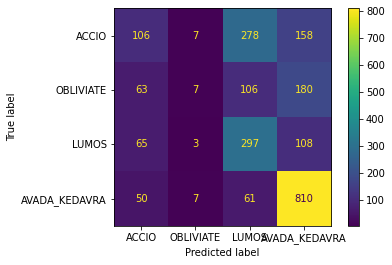

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.00843581972025053


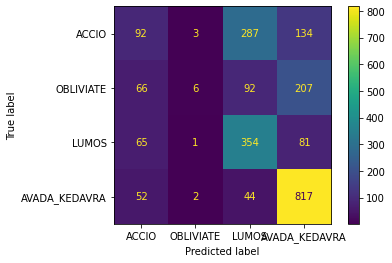

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.402255960305532, best loss: 3.402255960305532


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3644323269526164, best loss: 3.3644323269526164


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3014521559079486, best loss: 3.3014521559079486


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.298697018623352, best loss: 3.298697018623352


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2611811876297, best loss: 3.2611811876297


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.01208710171814522


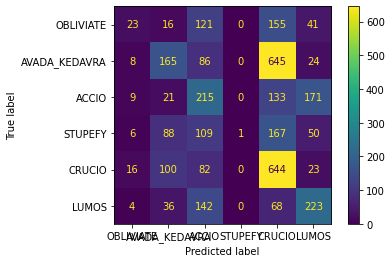

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.0124072430929615


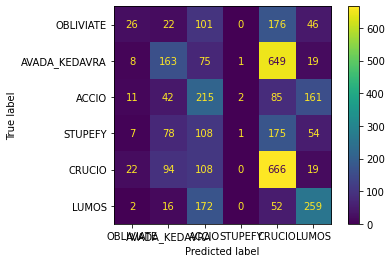

In [ ]:
params = [{"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 5,
                  "padding": 2,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": True

  }},
  {"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 5,
                  "padding": 2,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }},]


for param in params:
    val_score, test_score = fit_and_check_model(**param)
    RESULTS.append({"val_score": val_score,
                    "test_score": test_score,
                    "params": params,})

Из результата видно, что модель без droput слоя показывает качество лучше

Далее проверяется влияние размера ядра свертки на качество модели

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.4071796337763467, best loss: 3.4071796337763467


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3187641223271687, best loss: 3.3187641223271687


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.331949329376221, best loss: 3.3187641223271687


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2760520895322163, best loss: 3.2760520895322163


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2471765359242757, best loss: 3.2471765359242757


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.014968824444475025


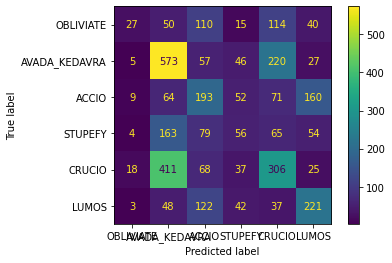

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.015004081731393889


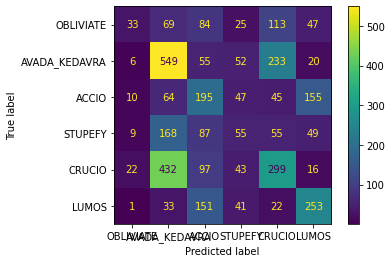

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.4021145939826964, best loss: 3.4021145939826964


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3636622707049053, best loss: 3.3636622707049053


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.301312963167826, best loss: 3.301312963167826


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2991596619288126, best loss: 3.2991596619288126


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2602808435757953, best loss: 3.2602808435757953


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.01247924937416733


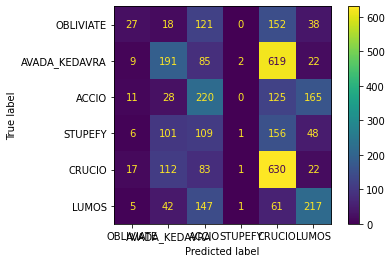

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.012582123219243761


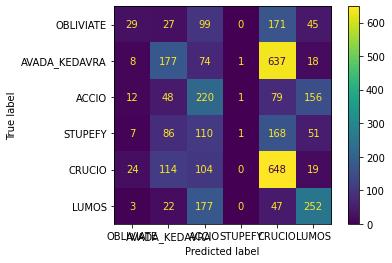

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.418933296203613, best loss: 3.418933296203613


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.364923691749573, best loss: 3.364923691749573


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3201215267181396, best loss: 3.3201215267181396


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.306529398759206, best loss: 3.306529398759206


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2971126317977903, best loss: 3.2971126317977903


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.00987702793987698


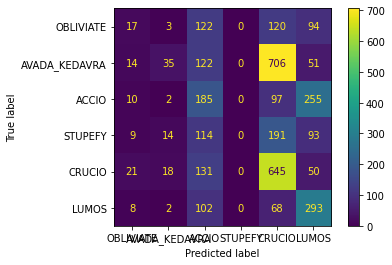

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.009246174303615108


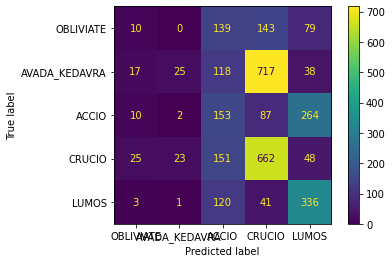

In [ ]:
params = [{"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 7,
                  "padding": 3,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }},
  {"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 5,
                  "padding": 2,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }},
  {"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 3,
                  "padding": 1,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }},]


for param in params:
    val_score, test_score = fit_and_check_model(**param)
    RESULTS.append({"val_score": val_score,
                    "test_score": test_score,
                    "params": params,})

Модель с размером ядра 7 показывает лучшее качество и ей удается побить лучший результат baseline модели.

Результаты обученных моделей

In [ ]:
pd.DataFrame(RESULTS)

,val_score,test_score,params
0,0.008379,0.008436,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
1,0.012087,0.012407,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
2,0.014969,0.015004,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
3,0.012479,0.012582,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
4,0.009877,0.009246,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."


Оценим влияне аугментации на модель, в аугментации случаным образом часть слов заменяется словами близкими по значению

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.4074153780937193, best loss: 3.4074153780937193


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.322111602624257, best loss: 3.322111602624257


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3307366132736207, best loss: 3.322111602624257


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2773532350858052, best loss: 3.2773532350858052


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2471345901489257, best loss: 3.2471345901489257


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.014839552673213626


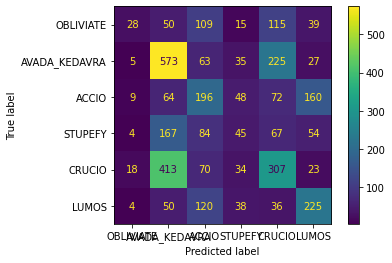

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.014804342171409442


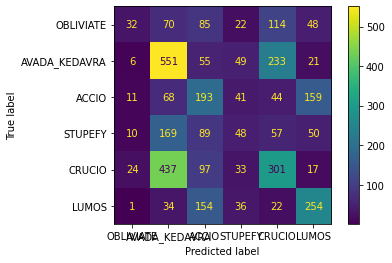

  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.408386063575745, best loss: 3.408386063575745


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.3144805312156675, best loss: 3.3144805312156675


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.319877107938131, best loss: 3.3144805312156675


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.280448309580485, best loss: 3.280448309580485


  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Val loss: 3.2501922408739725, best loss: 3.2501922408739725


  0%|          | 0/60 [00:00<?, ?it/s]

Val score:  0.014889538757225403


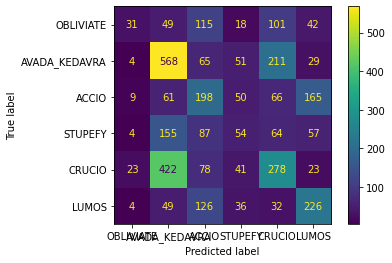

  0%|          | 0/60 [00:00<?, ?it/s]

Test score:  0.01518305057344384


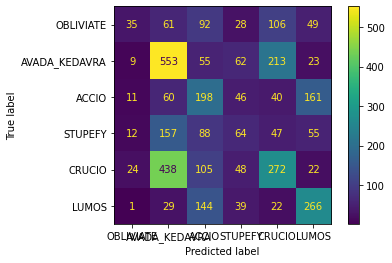

In [ ]:
params = [{"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": None,
  "model_params":{"kernel_size": 7,
                  "padding": 3,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }},
  {"num_epochs": 5, 
  "lr" : 0.03,
  "augmentation": add_augmentation,
  "model_params":{"kernel_size": 7,
                  "padding": 3,
                  "max_pool_kernel_size": 3,
                  "max_pool_padding": 0,
                  "channels_1": 100,
                  "channels_2": 128,
                  "channels_3": 172,
                  "linear_1": 256,
                  "use_max_pooling": False

  }}]


for param in params:
    val_score, test_score = fit_and_check_model(**param)
    RESULTS.append({"val_score": val_score,
                    "test_score": test_score,
                    "params": params,})

Испоьлзование аугментации дало прирост к качеству

In [ ]:
pd.DataFrame(RESULTS)

,val_score,test_score,params
0,0.008379,0.008436,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
1,0.012087,0.012407,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
2,0.014969,0.015004,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
3,0.012479,0.012582,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
4,0.009877,0.009246,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
5,0.014840,0.014804,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."
6,0.014890,0.015183,"[{'num_epochs': 5, 'lr': 0.03, 'augmentation':..."


Из Confusion матриц следуют аналогичные выводы, модлеь часто путает между сосбой "мирные" заклинания и "насильственные" заклинания

## Часть 4. [1 балл] Итоги

Напишите краткое резюме проделанной работы. Читали ли вы сами Гарри Поттера или фанфики о нем и помогло ли вам знание предметной области в выполнении домашнего задания?


**Ответ** За это домашнее задание:
1. Посчитали топ слова для **большого** корпуса текста.
2. Сложным заданием было найти все имена и фамилии в тексте, если бы не знание предметной области (то есть просто список персонажей), решать её было бы гораздо сложнее.
3. Знание предметной области безусловно помогло при валидации результатов анализа текстов.
4. Эмбеддинги слов, полученные с помощью FastText, выдают осмысленные синонимы и ассоциации, а также устойчивы к опечаткам и орфографическим ошибкам благодаря n-граммам.
5. Для задачи классификации тоже помогают знания предметной области, например, мы смогли уловить, что модель улавливает разницу между "мирными" заклинаниями и "насильствиенными", но путается внутри этих групп.